In [1]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from keras import regularizers
from keras.layers import Dense
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

data = pd.read_csv("data/imbalanced_job_data.csv")
model = SentenceTransformer("all-MiniLM-L6-v2")
tqdm.pandas(desc="Encoding Text")
data["encoding"] = data["text"].progress_apply(lambda x: model.encode(x))
data_features = pd.concat([data["telecommuting"], data["has_company_logo"], data["has_questions"], data["encoding"]], axis=1)
data_features = data_features.apply(lambda row: np.concatenate([row['telecommuting':'has_questions'], row['encoding']]), axis=1).tolist()
data_features = np.asarray(data_features).astype(np.float32)
train_encoding, test_encoding, train_category, test_category = train_test_split(data_features, data["fraudulent"].values, test_size=0.2, random_state=0)

2023-03-22 12:38:57.225663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Encoding Text: 100%|█████████████████████████████████████████████████████████████████████████████████████| 17880/17880 [23:27<00:00, 12.70it/s]


In [52]:
embedding_dim = train_encoding.shape[1]

model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=embedding_dim, kernel_regularizer=regularizers.l2(1e-6)))
model.add(Dropout(0.3))
model.add(Dense(units=40, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
model.add(Dropout(0.4))
model.add(Dense(units=40, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
model.add(Dropout(0.5))
model.add(Dense(units=40, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
model.add(Dense(units=10, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
model.add(Dense(units=5, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-6)))
sgd = SGD(learning_rate=1e-1)

model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_encoding, train_category, validation_data=(test_encoding, test_category), epochs=500, verbose=False)

112/112 [==============================] - 0s 1ms/step
Accuracy: 0.9813
ROC Accuracy: 0.8872


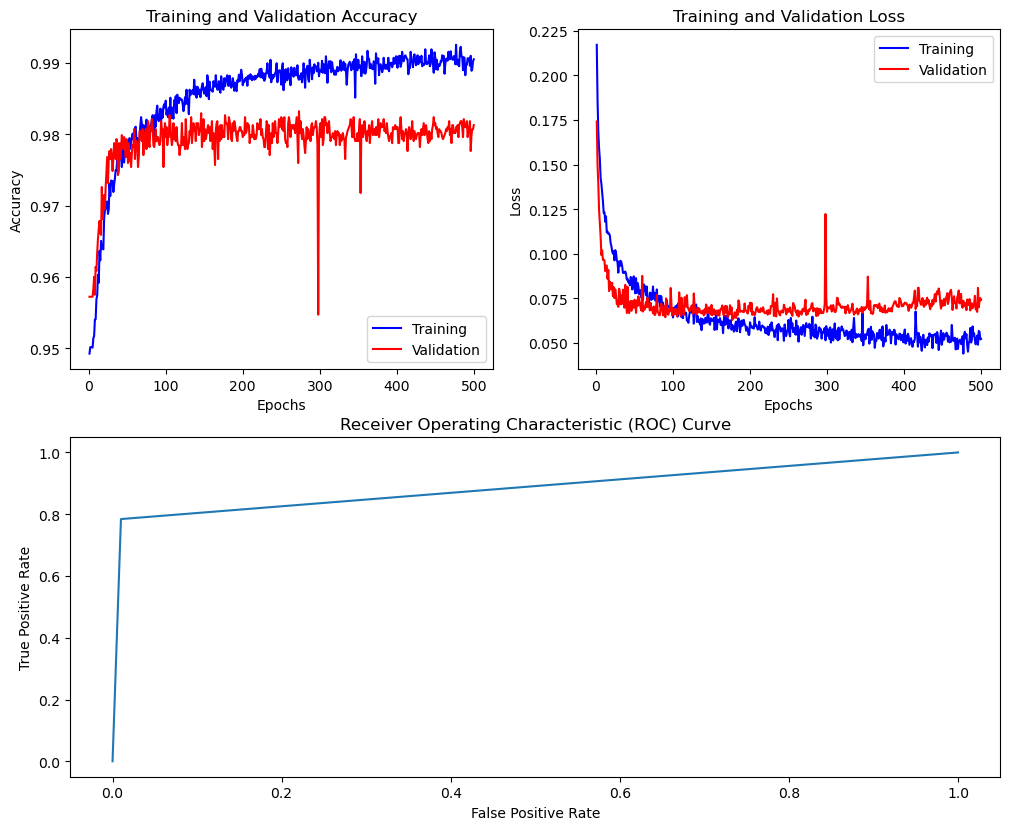

In [61]:
import matplotlib.pyplot as plt

def plot_history(history, fpr, tpr):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 15))
    plt.subplot(3, 2, 1)
    plt.plot(x, acc, 'b', label='Training')
    plt.plot(x, val_acc, 'r', label='Validation')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(3, 2, 2)
    plt.plot(x, loss, 'b', label='Training')
    plt.plot(x, val_loss, 'r', label='Validation')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(fpr, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

predicted_category = model.predict(test_encoding)
predicted_category = np.around(predicted_category, decimals=0)
acc_score = accuracy_score(test_category, predicted_category)
roc_score = roc_auc_score(test_category, predicted_category)
fpr, tpr, _ = roc_curve(test_category,  predicted_category)
plot_history(history, fpr, tpr)
print("Accuracy: {:.4f}\nROC Accuracy: {:.4f}".format(acc_score, roc_score))

In [62]:
print(classification_report(test_category, predicted_category, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3423
           1       0.78      0.78      0.78       153

    accuracy                           0.98      3576
   macro avg       0.88      0.89      0.89      3576
weighted avg       0.98      0.98      0.98      3576



<Axes: xlabel='Predicted', ylabel='Actual'>

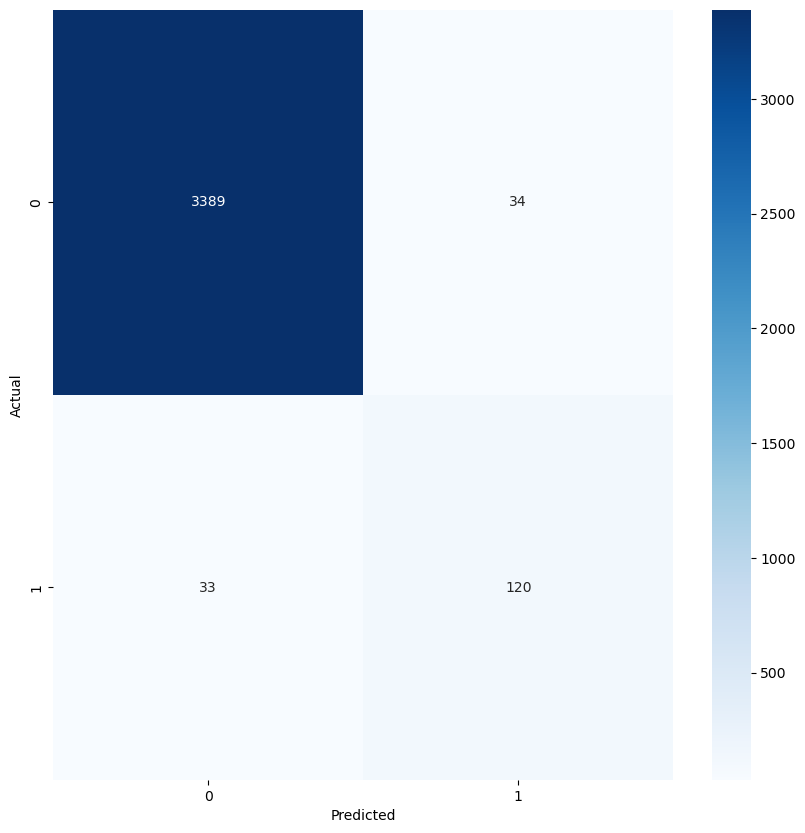

In [63]:
con_matrix = confusion_matrix(test_category, predicted_category)
con_matrix = pd.DataFrame(con_matrix, index=[0,1], columns=[0,1])
con_matrix.index.name = 'Actual'
con_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,10))
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


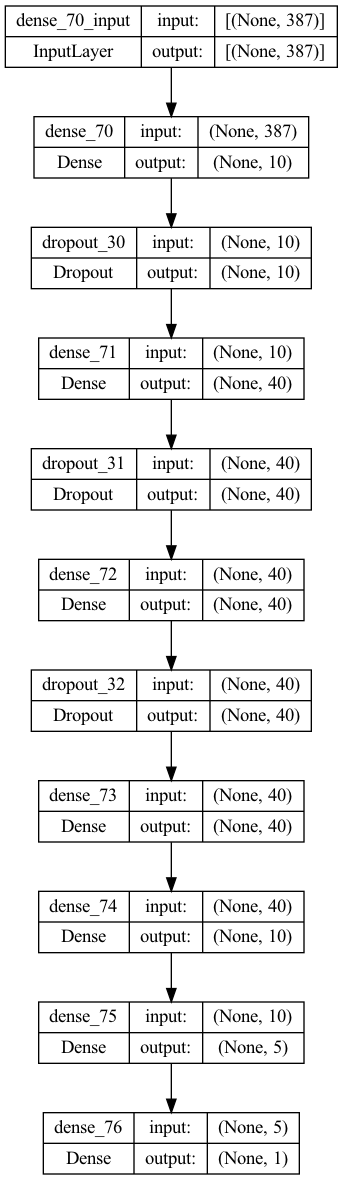

In [64]:
model.save("model/fake_job_model.h5")
plot_model(model, to_file='model.png', show_shapes=True)